In [0]:
%matplotlib inline

from matplotlib.pyplot import imshow

import numpy as np
import os
import sklearn
import sklearn.neighbors
import matplotlib.pyplot as plt
from IPython import display

import glob

import csv

import cv2

import pandas as pd

import itertools
import time
from tqdm import tqdm
import random
import tensorflow as tf
print(tf.VERSION)
import keras 
import keras.layers as layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GRU
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras import metrics

from functools import wraps
import os
import json

import requests
from requests.exceptions import Timeout

import pandas as pd

import shutil
from operator import itemgetter

from keras.callbacks import ModelCheckpoint
from keras.applications import DenseNet121, ResNet50,MobileNetV2


1.13.1


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

path_to_json= '/content/drive/My Drive/Colab Notebooks/metadata27638'
json_files =[x for x in os.listdir(path_to_json) if x.endswith('.json')]
json_data = []
for json_file in json_files:
    json_file_path = os.path.join(path_to_json,json_file)
    with open(json_file_path, "r", encoding="utf8") as f:
        json_data.append(json.load(f))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
metadata = pd.DataFrame(json_data)
metadata = pd.concat([metadata.drop(['attributes'],axis=1),metadata['attributes'].apply(pd.Series)],axis=1)

metadata.head()

,attribution,cookTime,cookTimeInSeconds,flavors,id,images,ingredientLines,name,numberOfServings,nutritionEstimates,prepTime,prepTimeInSeconds,rating,source,totalTime,totalTimeInSeconds,yield,course,cuisine,holiday
0,{'url': 'http://www.yummly.com/recipe/Mushroom...,NaN,NaN,{},Mushroom-risotto-352492,[{'hostedMediumUrl': 'http://lh3.ggpht.com/RWj...,"[2 cups Baby Bella mushrooms, sliced, 2 cups a...",Mushroom Risotto,6,"[{'attribute': 'FAT_KCAL', 'unit': {'name': 'c...",NaN,NaN,5,{'sourceSiteUrl': 'http://www.skinnytaste.com'...,30 minutes,1800.0,servings: 6,[Side Dishes],[Italian],NaN
1,{'url': 'http://www.yummly.com/recipe/Mushroom...,NaN,NaN,"{'Sweet': 0.3333, 'Sour': 0.8333, 'Salty': 0.3...",Mushroom-and-Roasted-Garlic-Risotto-525026,[{'hostedMediumUrl': 'http://lh5.ggpht.com/wbb...,"[2 whole garlic heads, 2 tablespoons plus 2 te...",Mushroom and Roasted Garlic Risotto,1,"[{'attribute': 'FAT_KCAL', 'unit': {'name': 'c...",NaN,NaN,3,"{'sourceSiteUrl': 'http://www.myrecipes.com', ...",1 Hr 25 Min,5100.0,Serves 6 (serving size: about 1 cup),[Main Dishes],[Italian],NaN
2,{'url': 'http://www.yummly.com/recipe/Gratin-D...,NaN,NaN,"{'Sweet': 0.1667, 'Sour': 0.6667, 'Salty': 0.8...",Gratin-Dauphinois-_scalloped-Potatoes-With-Che...,[{'hostedMediumUrl': 'http://lh4.ggpht.com/gfc...,"[1 garlic clove, halved, Cooking spray, 6 peel...",Gratin Dauphinois (Scalloped Potatoes with Che...,7,"[{'attribute': 'FAT_KCAL', 'unit': {'name': 'c...",NaN,NaN,4,"{'sourceSiteUrl': 'http://www.myrecipes.com', ...",55 min,3300.0,7 servings (serving size: 1 cup),[Side Dishes],"[French, American]",NaN
3,{'url': 'http://www.yummly.com/recipe/Filipino...,NaN,NaN,"{'Piquant': 0.5, 'Sour': 0.5, 'Salty': 0.8333,...",Filipino-bbq-pork-skewers-352163,[{'hostedMediumUrl': 'http://lh5.ggpht.com/aVk...,"[2.5 lb pork country style ribs, all fat trimm...",Filipino BBQ Pork Skewers,4,"[{'attribute': 'FAT_KCAL', 'unit': {'name': 'c...",NaN,NaN,5,{'sourceSiteUrl': 'http://www.skinnytaste.com'...,40 min,2400.0,None,[Main Dishes],[Barbecue],NaN
4,{'url': 'http://www.yummly.com/recipe/Hickory_...,NaN,NaN,"{'Sweet': 1.0, 'Sour': 0.1667, 'Salty': 0.8333...",Hickory_smoked-Bourbon-Turkey-My-Recipes,[{'hostedMediumUrl': 'http://lh6.ggpht.com/soG...,"[1 (11-pound) whole turkey, thawed, 2 cups map...",Hickory-Smoked Bourbon Turkey,14,"[{'attribute': 'FAT_KCAL', 'unit': {'name': 'c...",NaN,NaN,4,"{'sourceSiteUrl': 'http://www.myrecipes.com', ...",None,NaN,Makes 12 to 14 servings,[Main Dishes],[American],"[Winter, Christmas, Thanksgiving]"


In [0]:
print('length: ', len(metadata))
y = metadata.iloc[:,18].values
y_list = list(map(itemgetter(0), y))
print(len(y_list))

length:  500
500


In [0]:
# j=0
# writer_train = csv.writer(open('meta_train/train_labels.csv', 'w'))
# writer_test = csv.writer(open('meta_test/test_labels.csv', 'w'))
# for i in y_list:
#     if j < 19500:
#         writer_train.writerows([[i]])
#         print(i)
#         j+=1
#     else:
#         writer_test.writerows([[i]])
#         j+=1

In [0]:
train_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/meta_train/train_labels2.csv')
test_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/meta_test/test_labels.csv')
print('train shape: ', train_df.shape)
print('test shape: ', test_df.shape)
list_train = os.listdir('/content/drive/My Drive/Colab Notebooks/train_imgs')
list_test = os.listdir('/content/drive/My Drive/Colab Notebooks/test_imgs')# dir is your directory path
print('img train files: ', len(list_train))
print('img test files: ', len(list_test))
train_df.head()

train shape:  (500, 1)
test shape:  (7791, 1)
img train files:  500
img test files:  0


,cuisine
0,Italian
1,Barbecue
2,Italian
3,French
4,Barbecue


In [0]:
name_target_dict = train_df['cuisine'].to_dict()
train_image_names = os.listdir('/content/drive/My Drive/Colab Notebooks/train_imgs')
test_image_names = os.listdir('/content/drive/My Drive/Colab Notebooks/test_imgs')

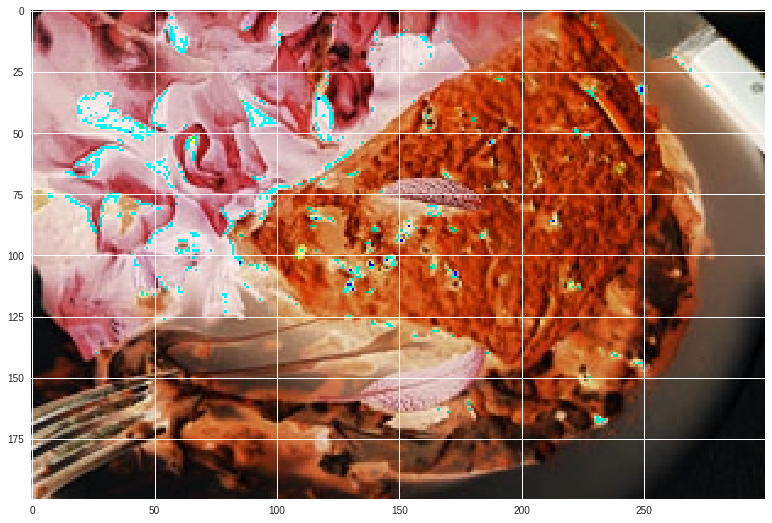

In [0]:
def display_samples(columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 3*rows))

    for i in range(columns*rows):
        image_path = train_image_names[i]
        img = cv2.imread(f'/content/drive/My Drive/Colab Notebooks/train_imgs/{image_path}')
        img = (img*255).astype(np.uint8)
#         plt.title(image_id)
        plt.imshow(img)

display_samples()

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
generator_dict = {'filename': [], 'class': []}

for name in train_image_names:
#     print(name)
    generator_dict['filename'].append(name)


# print(name_target_dict)
for key, value in name_target_dict.items():
    generator_dict['class'].append(value)

print(len(generator_dict['filename']))

print(len(generator_dict['class']))

generator_df = pd.DataFrame(generator_dict)
generator_df.head(8)

500
500


,class,filename
0,Italian,img00001.jpg
1,Barbecue,img00002.jpg
2,Italian,img00003.jpg
3,French,img00006.jpg
4,Barbecue,img00007.jpg
5,American,img00005.jpg
6,American,img00004.jpg
7,Italian,img00010.jpg


In [0]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    shear_range=0.1,  # set range for random shear
    zoom_range=0.1,  # set range for random zoom
    channel_shift_range=0.,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=1/255.,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.1
)

In [0]:
def create_generator(subset):
    return datagen.flow_from_dataframe(
        generator_df, 
        '/content/drive/My Drive/Colab Notebooks/train_imgs', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(100, 100), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=128, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
val_generator = create_generator('validation')

Found 450 images belonging to 15 classes.
Found 50 images belonging to 15 classes.


In [0]:
model = DenseNet121(
    weights=None, 
    include_top=True, 
    classes=15,
    input_shape=(100, 100, 3)
)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [0]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [0]:
setattr(tf.contrib.rnn.GRUCell, '__deepcopy__', lambda self, _: self)
setattr(tf.contrib.rnn.BasicLSTMCell, '__deepcopy__', lambda self, _: self)
setattr(tf.contrib.rnn.MultiRNNCell, '__deepcopy__', lambda self, _: self)



In [0]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100, 
    epochs=5,
    callbacks=[checkpoint],
    validation_data=val_generator,
    use_multiprocessing=False,
    workers=2, 
    verbose=1,
    validation_steps = 1
)

Epoch 1/5
100/100 [==============================] - 87s 866ms/step - loss: 0.0645 - acc: 0.9811 - val_loss: 9.7500 - val_acc: 0.1200
Epoch 2/5
100/100 [==============================] - 83s 834ms/step - loss: 0.0318 - acc: 0.9917 - val_loss: 6.1713 - val_acc: 0.3000
Epoch 3/5
100/100 [==============================] - 84s 838ms/step - loss: 0.0083 - acc: 0.9979 - val_loss: 6.0935 - val_acc: 0.3000
Epoch 4/5
100/100 [==============================] - 84s 837ms/step - loss: 0.0148 - acc: 0.9956 - val_loss: 5.7612 - val_acc: 0.2400
Epoch 5/5
100/100 [==============================] - 84s 835ms/step - loss: 0.0167 - acc: 0.9955 - val_loss: 6.8656 - val_acc: 0.2400


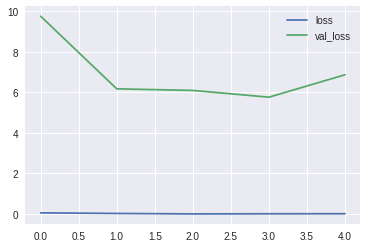

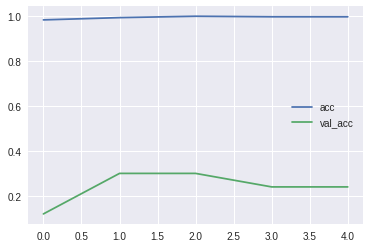

In [0]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()